In [1]:
from qutip import *
import numpy as np 
import matplotlib.pyplot as plt 
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['animation.embed_limit'] = 100

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
#Functions

#Make Wigner functions
def make_wigners(x, t, result):  
    print("Making wigner functions")
    wigner_array = np.empty([len(t),len(x),len(x)])
    f = IntProgress(min=0, max=len(t)-1) # instantiate the bar
    display(f) # display the bar
    for i in range(0, len(t)):
        wig = wigner(result.states[i],x,x)
        wigner_array[i,:,:] = wig
        f.value=i
        
    return wigner_array

#Make animation of evolution of Wigner function
def make_animation(x, t, wigner, eps):
    f = IntProgress(min=0, max=len(t)-1) # instantiate the bar
    
    extent = [x[0],x[-1],x[0],x[-1]]
    fig = plt.figure()
    plane = plt.imshow(wigner[0,:,:], cmap = 'RdBu', vmin = -np.max(wigner[0,:,:]), vmax = np.max(wigner[0,:,:]), extent = extent, origin = 'lower');
    plt.ylabel(r'$Im(\alpha)$')
    plt.xlabel(r'$Re(\alpha)$')
    plt.colorbar()
    title = plt.title(r'Wigner function, $\epsilon$ = %.2f K' %(eps*50))
    plt.close(fig)
    
    def animate(i):
        if (i == 1):
            print("Generating animation")
            display(f) # display the bar
        wig_i = wigner[i,:,:]
        plane.set_data(wig_i)
        f.value = i
        return plane,
    
    anim = animation.FuncAnimation(fig, animate,frames=len(t), interval = 30)
    
    return anim

# The Kerr-Nonlinear Resonator

We consider an undamped Duffing oscillator in the Kerr approximation, the Kerr-Nonlinear Resonator (KNR). In the lab frame we have the following Hamiltonian:

$$
\begin{equation}
\hat{H}_{lab} = (\hbar \omega_0 - 2K)\hat{a}^{\dagger}\hat{a} - K\hat{a}^{\dagger}\hat{a}^{\dagger}\hat{a}\hat{a},
\end{equation}
$$

where $\omega_0$ is the natural frequency of the harmonic oscillator and $K$ is the anharmonicity. (The ground state energy is set to 0.) 

A redefinition of the eigenfrequency leads to the following expression: 

$$
\begin{equation}
\hat{H}_{lab} = \hbar \omega_K \hat{a}^{\dagger}\hat{a} - K\hat{a}^{\dagger}\hat{a}^{\dagger}\hat{a}\hat{a},
\end{equation}
$$
with $\omega_K = \omega_0 - \frac{2K}{\hbar}$.  

When we transform to the rotating frame using the unitary $\hat{U}(t) = e^{-i \omega_K \hat{a}^{\dagger}\hat{a} t}$ we find: 

$$
\begin{equation}
\hat{H}_{rot} = - K\hat{a}^{\dagger}\hat{a}^{\dagger}\hat{a}\hat{a}.
\end{equation}
$$

Both the Hamiltonian in the lab frame and rotating frame have an equal amount of creation and annihilation operators in all of their terms. Using this fact, it is easily verified that the eigenstates of $\hat{H}_{lab}$ and $\hat{H}_{rot}$ are Fock (occupation number) states, $\left | n \right \rangle$. The result is explicitly shown for the lab frame: 

$$
\begin{equation}
\hat{H}_{lab}\left | n \right \rangle = (\hbar \omega_K n - K n (n-1))\left | n \right \rangle.
\end{equation}
$$

The energies associated with the states are given by: 

$$
\begin{equation}
E_n = n \hbar \omega_K - K n (n-1)) = n(\hbar \omega_0 - 2K) - Kn(n-1).
\end{equation}
$$ 

The first term is equivalent to the spectrum of a harmonic oscillator with a spacing of $\hbar \omega_K$. Furthermore, the non-linear part of the Hamiltonian lowers the energies by $K n (n-1)$. This term causes the level spacing to decrease with increasing $n$. 

The states and energies of the Kerr-Nonlinear Resonator are calculated and compared to the analytical results found above.

In [4]:
N = 20                               #Size of Hilbert space
a = destroy(N)                       #Define annihilation and creation operators
a_dag = create(N)
n = a_dag*a                          #Define number operator

In [5]:
#Define Hamiltonians
K = 1/50                                              #Set hbar = 1,w_K = 1, K is relative to w_K

H_lab = a_dag*a-K*a_dag*a_dag*a*a                    #Hamiltonian, hbar = 1, w_K = 1
H_rot = -K*a_dag*a_dag*a*a
H_ho = a_dag*a                                       #Hamiltonian of harmonic oscillator with frequency w_K                                  

#Solve for energies and states
Energies_lab, States_lab = H_lab.eigenstates()
Energies_rot, States_rot = H_rot.eigenstates()
Energies_ho, States_ho = H_ho.eigenstates()

In [6]:
#Plot Wigner functions of first 5 eigenstates
x = np.linspace(-6,6,400)

wigner_functions = np.empty([9,len(x),len(x)])
for i in range(0,9):
    wig = wigner(States_lab[i],x,x)
    wigner_functions[i,:,:] = wig

def wigner_interact_plot(State = 0):
    extent = [x[0],x[-1],x[0],x[-1]]
    plt.figure(figsize=(6,6))
    plt.imshow(wigner_functions[State,:,:], cmap = 'RdBu', vmin = -np.max(wigner_functions[0,:,:]), vmax = np.max(wigner_functions[0,:,:]), extent = extent, origin = 'lower');
    plt.ylabel(r'$Im(\alpha)$')
    plt.xlabel(r'$Re(\alpha)$')
    plt.colorbar()
    title = plt.title("Wigner Functions")

interact(wigner_interact_plot, State =(0,8));

interactive(children=(IntSlider(value=0, description='State', max=8), Output()), _dom_classes=('widget-interac…

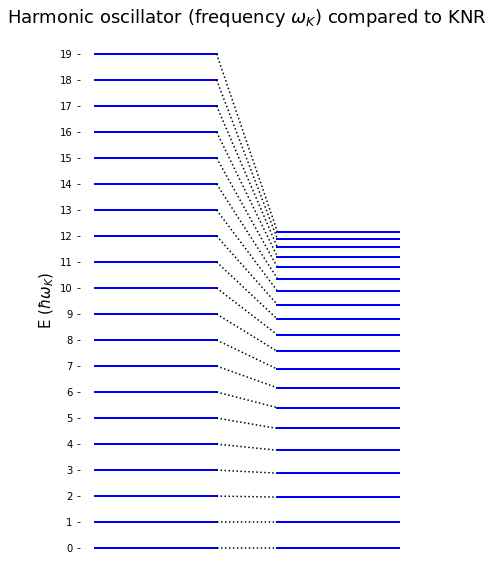

In [7]:
#Order energies according to state number
n_expect = expect(n, States_lab)

Energies_lab_ordered = np.zeros(N)
for i in np.arange(0,N):
    j = np.int(np.rint(n_expect[i]))
    Energies_lab_ordered[j] = Energies_lab[i]

#Calculate level spacing of KNR (Numerical)
E_dif = np.empty(len(Energies_lab_ordered)-1)
for i in range(0,len(Energies_lab_ordered)-1): 
    E_dif[i] = Energies_lab_ordered[i+1]-Energies_lab_ordered[i]

#Calculate level spacing of KNR (Analytical) 
numb = np.arange(0,N,1)
En = numb - K*numb*(numb-1)

lev_spacing = np.empty(len(numb)-1)
for i in range(0,len(numb)-1):
    lev_spacing[i] = En[i+1]-En[i]
    
#Plot energy level diagram
fig, ax = plt.subplots()
fig.set_size_inches(6,10)
ax.set_ylabel(r'E ($\hbar$$\omega_K$)', fontsize = 15)
ax.set_title(r'Harmonic oscillator (frequency $\omega_K$) compared to KNR', fontsize = 18)
plot_energy_levels([H_ho, H_rot], N = 21 , show_ylabels=True, fig = fig, ax=ax);

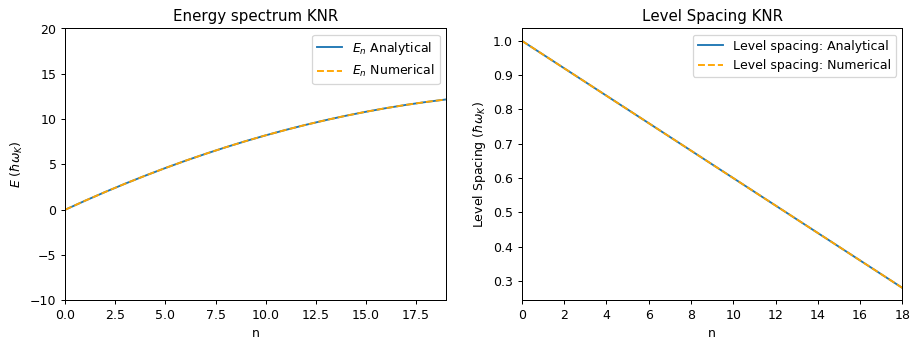

In [8]:
#Plot of energy spectrum of Kerr oscillator and level spacing
fig = plt.figure(dpi = 90)
fig.set_size_inches(12,4)
ax1 = fig.add_subplot(121)
ax1.set_title("Energy spectrum KNR")
ax2 = fig.add_subplot(122)
ax2.set_title("Level Spacing KNR")

ax1.plot(numb, En, label = r'$E_n$ Analytical');
ax1.plot(numb, Energies_lab_ordered, label = r'$E_n$ Numerical', ls = '--', color = 'orange')
ax1.set_ylabel(r'$E$ $(\hbar \omega_K)$')
ax1.set_xlabel('n')
ax1.set_xlim(0,len(numb)-1)
ax1.set_ylim(-10,20);
ax1.legend()

ax2.plot(numb[0:len(numb)-1], lev_spacing, label = 'Level spacing: Analytical')
ax2.plot(numb[0:len(numb)-1], E_dif, label = r'Level spacing: Numerical', ls = '--', color = 'orange')
ax2.set_ylabel(r'Level Spacing $(\hbar \omega_K)$')
ax2.set_xlabel('n')
ax2.set_xlim(0,len(numb)-2);
ax2.legend();

It is observed that the numerical and analytical spectra coincide exactly and that the eigenstates are indeed Fock states. From a certain $n$ the level spacing becomes negative and this results in degenerate energies. These states do not correspond to stationary states of a nonlinear potential well. We could think of them as being close to or even above the top of the well. Because of this they are not of our interest in our study of nonlinear oscillator potentials. This however results in a computational advantage: the Hilbert space can be truncated at a relatively small size and provide us with exactly the states that we want to study.

# Driving

The dynamics of the Kerr-Nonlinear Resonator are studied in the case of a linear (single-photon) drive. The driving frequency will be resonant with the first transition: $\hbar \omega_K$. 
The Hamiltonian of the KNR with a linear drive in the lab frame is given by: 

$$
\begin{equation}
\hat{H}_{lab,lin.drive} = \hbar \omega_K \hat{a}^{\dagger}\hat{a} - K\hat{a}^{\dagger} \hat{a}^{\dagger}\hat{a}\hat{a} + \varepsilon _l \cos(\omega_K t)(\hat{a}^{\dagger}+\hat{a}),
\end{equation}
$$
where $\epsilon_l$ is the drive amplitude. 

Expanding the cosine and transforming to the rotating frame yields: 

$$
\begin{equation}
\hat{H}_{rot,lin.drive} = - K\hat{a}^{\dagger}\hat{a}^{\dagger}\hat{a}\hat{a} + \frac{\varepsilon _l}{2}(\hat{a}^{\dagger}+\hat{a}) + \frac{\varepsilon _l}{2}(\hat{a}^{\dagger}e^{i2\omega_Kt}+\hat{a}e^{-i2\omega_K t}) .
\end{equation}
$$


In the rotating wave approximation the fast rotating terms are omitted and the rotating drive is obtained: 

$$
\begin{equation}
\hat{H}_{rot,rot.drive} = - K\hat{a}^{\dagger}\hat{a}^{\dagger}\hat{a}\hat{a} + \frac{\varepsilon _l}{2}(\hat{a}^{\dagger}+\hat{a}).
\end{equation}
$$

Finally, transforming back to the lab frame and defining $\varepsilon_r = \frac{\varepsilon_l}{2}$: 

$$
\begin{equation}
\hat{H}_{lab,rot.drive} = \hbar \omega_K \hat{a}^{\dagger}\hat{a} - K\hat{a}^{\dagger}\hat{a}^{\dagger}\hat{a}\hat{a} + \varepsilon_r(\hat{a}^{\dagger}e^{-i \omega_K t}+\hat{a}e^{ i\omega_K t}).
\end{equation}
$$


For a 2-level system and a drive in the rotating wave approximation the oscillation frequency between the vacuum and single-photon Fock state, known as the Rabi frequency, can be calculated analytically. The Rabi frequency is given by: 

$$
\begin{equation}
\omega_r = \frac{1}{2} \sqrt{(\omega_d - \omega_K)^2+ \left(\frac{\left |\varepsilon_l \right |}{\hbar} \right )^2},
\end{equation}
$$

where $\omega_d$ is the driving frequency. If the sytsem is driven at resonance we find $\omega_r = \frac{\varepsilon_l}{2\hbar}$. The approximation of a 2-level system is valid as long as the drive does not excite the system to the second excited state, typically this means that the drive amplitude $\varepsilon_r$ should be smaller than the anharmonicty $K$.

The simulation starts with the easiest case: the time-indepent Hamiltonian of the rotating drive in the rotating frame. This is followed by a simulation of the rotating drive in the lab frame and finally the rotating wave approximation of the drive is relaxed to simulate the full linear drive in the lab frame. In all of these situations 4 drive strengths are considered. They are numbered as follows: 

|   | $\varepsilon_l$ |
|---|-----------------|
| 0 | 0.1 K           |
| 1 | 0.4 K           |
| 2 | 0.7 K           |
| 3 | 1.0 K           |

## Rotating drive

#### Rotating Frame

In [9]:
K = 1/50
eps_l = np.array([0.1*K, 0.4*K, 0.7*K, 1*K])                    #Driving strength relative to K
eps_r = 0.5*eps_l

In [10]:
#Define t and x arrays
steps_rot = 1000                                                #Number of time steps
t_rot = np.empty([len(eps_r),steps_rot])
for i in range(len(eps_r)):
    t = np.linspace(0,1*np.pi/eps_r[i],steps_rot)               #Since hbar = 1, w_K = 1, time will be measured in 1/w_K
    t_rot[i,:] = t

x_rot = np.linspace(-5,5,50)

#Define operators to calculate probabilities 
g0 = fock(N,0)*fock(N,0).dag()
e1 = fock(N,1)*fock(N,1).dag()
f2 = fock(N,2)*fock(N,2).dag()


#Calculating expectation values and standard deviations for various drive strengths
expect_array_rot = np.empty([len(eps_r),steps_rot])
stdev_array_rot = np.empty([len(eps_r),steps_rot])
g_array_rot = np.empty([len(eps_r),steps_rot])
e_array_rot = np.empty([len(eps_r),steps_rot])
f_array_rot = np.empty([len(eps_r),steps_rot])

f = IntProgress(min=0, max=len(eps_r)-1)                     #Instantiate progress bar
print('Progress')
display(f)                                                   #display the bar
for i in range(len(eps_r)):
    H_rot_rotdrive = -K*a_dag*a_dag*a*a + eps_r[i]*(a_dag+a)      
    psi0 = basis(N,0)
    result_psi0 = mesolve(H_rot_rotdrive, psi0, t_rot[i,:], c_ops = [], e_ops = [n, n**2, g0, e1, f2])
    
    expect_array_rot[i,:] = result_psi0.expect[0]
    stdev_array_rot[i,:] = np.sqrt(result_psi0.expect[1]-result_psi0.expect[0]**2)
    g_array_rot[i,:] = result_psi0.expect[2]
    e_array_rot[i,:] = result_psi0.expect[3]
    f_array_rot[i,:] = result_psi0.expect[4]
    f.value=i

Progress


IntProgress(value=0, max=3)

In [11]:
def Occupation_interact_plot(Drive = 0):
    plt.figure(figsize = (10,8), dpi = 200)
    plt.plot(t_rot[Drive,:],expect_array_rot[Drive,:], label = r'$\left \langle n \right \rangle$', c = 'midnightblue', lw = '2')
    plt.plot(t_rot[Drive,:],stdev_array_rot[Drive,:],label = r'$\sigma_n$', c = 'sandybrown', lw = '2')
  
    #plt.title('Rotating drive, rotating frame, $\epsilon_l$ = %.2f K' %(eps_l[Drive]*50), fontsize = 16)
    #plt.xlabel(r't ($\frac{1}{\omega_K})$', fontsize = 16)
    plt.xlabel(r'$t$ (s)', fontsize = 16)
    plt.ylabel('$n$', fontsize = 16)
    plt.axhline(1,ls=':',c='grey')
    #plt.axvline(200*np.pi)
    plt.xlim(0, t_rot[Drive,:][-1])
    plt.ylim(0)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(loc='upper right', fontsize = 18);
    #plt.savefig('Expect_Kerr_Lin_psi0=0_Rot_eps=%.2fK.png' %(eps_l[Drive]/K))

interact(Occupation_interact_plot, Drive =(0,len(eps_l)-1));

interactive(children=(IntSlider(value=0, description='Drive', max=3), Output()), _dom_classes=('widget-interac…

In [13]:
def Probability_interact_plot(Drive = 0):
    plt.figure(figsize = (10,8), dpi = 200)
    plt.plot(t_rot[Drive,:],g_array_rot[Drive,:], label = r'$P (\left | 0 \right \rangle$)', c = 'midnightblue', lw = '2')
    plt.plot(t_rot[Drive,:],e_array_rot[Drive,:], label = r'$P (\left | 1 \right \rangle$)', c = 'sandybrown', lw = '2')
    plt.plot(t_rot[Drive,:],f_array_rot[Drive,:], label = r'$P (\left | 2 \right \rangle$)', c = 'orangered', lw = '2')

    #plt.title('Rotating drive, rotating frame, $\epsilon_l$ = %.2f K' %(eps_l[Drive]*50), fontsize = 16)
    #plt.xlabel(r't ($\frac{1}{\omega_K})$', fontsize = 16)
    plt.xlabel(r'$t$ (s)', fontsize = 16)
    plt.ylabel(r'Probability', labelpad= 15, fontsize = 16)
    plt.axhline(1,ls=':',c='grey')
    plt.xlim(0, t_rot[Drive,:][-1])
    plt.ylim(0)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(loc='upper right', fontsize = 18);
    #plt.savefig('Probabilities_Kerr_Lin_psi0=0_Rot_eps=%.2fK.png' %(eps_l[Drive]/K))

interact(Probability_interact_plot, Drive =(0,len(eps_l)-1));

interactive(children=(IntSlider(value=0, description='Drive', max=3), Output()), _dom_classes=('widget-interac…

In [ ]:
#Make animation of Wigner functions
Drive_num = input("Select drive number (0-3):\n")
Drive_num = int(Drive_num)

H_rot_rotdrive = -K*a_dag*a_dag*a*a + eps_r[Drive_num]*(a_dag+a)      
psi0 = basis(N,0)
result_psi0 = mesolve(H_rot_rotdrive, psi0, t_rot[Drive_num,:], [])
wigner_rot_rotdrive = make_wigners(x_rot,t_rot[Drive_num,:],result_psi0)
anim = make_animation(x_rot,t_rot[Drive_num,:], wigner_rot_rotdrive, eps_l[Drive_num])
anim

In [ ]:
#Plot Wigner functions of first 5 eigenstates of driven Hamiltonian
x = np.linspace(-6,6,400)

H_rot_rotdrive = -K*a_dag*a_dag*a*a + eps_r[3]*(a_dag+a)      
Energies_rot_rotdrive, States_rot_rotdrive = H_rot_rotdrive.eigenstates()

wigner_functions_rot = np.empty([5,len(x),len(x)])
for i in range(0,5):
    wig = wigner(np.flip(States_rot_rotdrive)[i],x,x)
    wigner_functions_rot[i,:,:] = wig

def wigner_interact_plot(State = 0):
    extent = [x[0],x[-1],x[0],x[-1]]
    plt.figure(figsize=(10,10), dpi = 100)
    plt.imshow(wigner_functions_rot[State,:,:], cmap = 'RdBu', vmin = -np.max(wigner_functions_rot[0,:,:]), vmax = np.max(wigner_functions_rot[0,:,:]), extent = extent, origin = 'lower');
    plt.ylabel(r'$Im(\alpha)$', fontsize = 16)
    plt.xlabel(r'$Re(\alpha)$', fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=16)
    #title = plt.title(r'Rotating drive, $\epsilon_l$ = 0.1 K, n = %.d' %(State))
    #plt.savefig('Wigner_Kerr_Lin_Eigenstate_%.2f_Rot_eps=0.1K.png' %(State))

interact(wigner_interact_plot, State =(0,4));

#### Lab Frame

In [ ]:
#Setting up time-dependent Hamiltonian
H_lab = a_dag*a-K*a_dag*a_dag*a*a   
w_K = 1     

In [ ]:
#Define t and x arrays
steps_lab = 2500                                                #Number of time steps
t_lab = np.empty([len(eps_r),steps_lab])
for i in range(len(eps_r)):
    t = np.linspace(0,2*np.pi/eps_r[i],steps_lab)               #Since hbar = 1, w_K = 1, time will be measured in 1/w_K
    t_lab[i,:] = t

x_lab = np.linspace(-5,5,50)

#Calculating expectation values and standard deviations for various drive strengths
expect_array_lab = np.empty([len(eps_r),steps_lab])
stdev_array_lab = np.empty([len(eps_r),steps_lab])
g_array_lab = np.empty([len(eps_r),steps_lab])
e_array_lab = np.empty([len(eps_r),steps_lab])
f_array_lab = np.empty([len(eps_r),steps_lab])

f = IntProgress(min=0, max=len(eps_r)-1)               # instantiate progress bar
print('Progress')
display(f)                                             # display the bar
for i in range(len(eps_r)):
    H_drive1 = eps_r[i]*a_dag
    H_drive2 = eps_r[i]*a
    
    def H_drive_coeff1(t,args):                                                      
        return np.exp(-1j*w_K*t)

    def H_drive_coeff2(t,args):
        return np.exp(+1j*w_K*t)
    
    H_lab_rotdrive = [H_lab, [H_drive1, H_drive_coeff1], [H_drive2, H_drive_coeff2]] 
     
    psi0 = basis(N,0)
    result_psi0 = mesolve(H_lab_rotdrive, psi0, t_lab[i,:], c_ops =[], e_ops = [n, n**2, g0, e1, f2])
    
    expect_array_lab[i,:] = result_psi0.expect[0]
    stdev_array_lab[i,:] = np.sqrt(result_psi0.expect[1]-result_psi0.expect[0]**2)
    g_array_lab[i,:] = result_psi0.expect[2]
    e_array_lab[i,:] = result_psi0.expect[3]
    f_array_lab[i,:] = result_psi0.expect[4]
    f.value=i

In [ ]:
def Occupation_interact_plot(Drive = 0):
    plt.figure(figsize = (10,7))
    plt.plot(t_lab[Drive,:],expect_array_lab[Drive,:], label = r'$\left \langle n \right \rangle$')
    plt.plot(t_lab[Drive,:],stdev_array_lab[Drive,:],label = r'$\sigma_n$')
 
    plt.title('Rotating drive, lab frame, $\epsilon_l$ = %.2f K' %(eps_l[Drive]*50), fontsize = 16)
    plt.xlabel(r't ($\frac{1}{\omega_K})$', fontsize = 16)
    plt.ylabel('n', fontsize = 16)
    plt.axhline(1,ls=':',c='grey')
    plt.xlim(0, t_lab[Drive,:][-1])
    plt.legend(loc='upper right');

interact(Occupation_interact_plot, Drive =(0,len(eps_l)-1));

In [ ]:
def Probability_interact_plot(Drive = 0):
    plt.figure(figsize = (10,7))
    plt.plot(t_lab[Drive,:],g_array_lab[Drive,:], label = r'$P (\left | 0 \right \rangle$)')
    plt.plot(t_lab[Drive,:],e_array_lab[Drive,:], label = r'$P (\left | 1 \right \rangle$)')
    plt.plot(t_lab[Drive,:],f_array_lab[Drive,:], label = r'$P (\left | 2 \right \rangle$)')

    plt.title('Rotating drive, lab frame, $\epsilon_l$ = %.2f K' %(eps_l[Drive]*50), fontsize = 16)
    plt.xlabel(r't ($\frac{1}{\omega_K})$', fontsize = 16)
    plt.ylabel('P', fontsize = 16)
    plt.axhline(1,ls=':',c='grey')
    plt.xlim(0, t_lab[Drive,:][-1])
    plt.ylim(0)
    plt.legend(loc='upper right');

interact(Probability_interact_plot, Drive =(0,len(eps_l)-1));

In [ ]:
#Make animation of Wigner functions
Drive_num = input("Select drive number (0-3):\n")
Drive_num = int(Drive_num)

H_drive1 = eps_r[Drive_num]*a_dag
H_drive2 = eps_r[Drive_num]*a
    
def H_drive_coeff1(t,args):                                                      
        return np.exp(-1j*w_K*t)

def H_drive_coeff2(t,args):
        return np.exp(1j*w_K*t)
    
H_lab_rotdrive = [H_lab, [H_drive1, H_drive_coeff1], [H_drive2, H_drive_coeff2]] 
psi0 = basis(N,0)
result_psi0 = mesolve(H_lab_rotdrive, psi0, t_lab[Drive_num,:], [])

wigner_lab_rotdrive = make_wigners(x_lab,t_lab[Drive_num,:],result_psi0)
anim = make_animation(x_lab,t_lab[Drive_num,:], wigner_lab_rotdrive, eps_l[Drive_num])
anim

## Linear Drive

#### Lab Frame

In [ ]:
K = 1/50
eps_l = [0.1*K, 0.4*K, 0.7*K, 1*K]                          #Driving strength relative to K 
w_K = 1    
H_lab = a_dag*a-K*a_dag*a_dag*a*a   

In [ ]:
#Define t and x arrays
steps_lin = 10000                                                #Number of time steps
t_lin = np.empty([len(eps_l),steps_lin])
for i in range(len(eps_l)):
    t = np.linspace(0,4*np.pi/eps_l[i],steps_lin)               #Since hbar = 1, w_K = 1, time will be measured in 1/w_K
    t_lin[i,:] = t

x_lin = np.linspace(-5,5,50)

#Calculating expectation values and standard deviations for various drive strengths
expect_array_lin = np.empty([len(eps_l),steps_lin])
stdev_array_lin = np.empty([len(eps_l),steps_lin])
g_array_lin = np.empty([len(eps_l),steps_lin])
e_array_lin = np.empty([len(eps_l),steps_lin])
f_array_lin = np.empty([len(eps_l),steps_lin])

f = IntProgress(min=0, max=len(eps_l)-1)               # instantiate progress bar
print('Progress')
display(f)                                             # display the bar
for i in range(len(eps_l)):
    H_drive = eps_l[i]*(a_dag+a)
    
    def H_drive_coeff(t,args):                                                      
        return np.cos(w_K*t)      
    
    H_lab_lindrive = [H_lab, [H_drive, H_drive_coeff]] 
    
    psi0 = basis(N,0)
    result_psi0 = mesolve(H_lab_lindrive, psi0, t_lin[i,:], c_ops =[], e_ops = [n, n**2, g0, e1, f2])
    
    expect_array_lin[i,:] = result_psi0.expect[0]
    stdev_array_lin[i,:] = np.sqrt(result_psi0.expect[1]-result_psi0.expect[0]**2)
    g_array_lin[i,:] = result_psi0.expect[2]
    e_array_lin[i,:] = result_psi0.expect[3]
    f_array_lin[i,:] = result_psi0.expect[4]
    f.value=i

In [ ]:
def Occupation_interact_plot(Drive = 0):
    plt.figure(figsize = (10,7))
    plt.plot(t_lin[Drive,:],expect_array_lin[Drive,:], label = r'$\left \langle n \right \rangle$')
    plt.plot(t_lin[Drive,:],stdev_array_lin[Drive,:],label = r'$\sigma_n$')
  
    plt.title('Linear drive, lab frame, $\epsilon_l$ = %.2f K' %(eps_l[Drive]/K), fontsize = 16)
    plt.xlabel(r't ($\frac{1}{\omega_K})$', fontsize = 16)
    plt.ylabel('n', fontsize = 16)
    plt.axhline(1,ls=':',c='grey')
    plt.xlim(0, t_lin[Drive,:][-1])
    #plt.ylim(0.98,1.02)
    #plt.legend(loc='upper right');

interact(Occupation_interact_plot, Drive =(0,len(eps_l)-1));

In [ ]:
def Probability_interact_plot(Drive = 0):
    plt.figure(figsize = (10,8), dpi = 200)
    plt.plot(t_lin[Drive,:],g_array_lin[Drive,:], label = r'$P (\left | 0 \right \rangle$)', c = 'midnightblue', lw = '2')
    plt.plot(t_lin[Drive,:],e_array_lin[Drive,:], label = r'$P (\left | 1 \right \rangle$)', c = 'sandybrown', lw = '2')
    plt.plot(t_lin[Drive,:],f_array_lin[Drive,:], label = r'$P (\left | 2 \right \rangle$)', c = 'orangered', lw = '2')

    #plt.title('Linear drive, lab frame, $\epsilon_l$ = %.2f K' %(eps_l[Drive]*50), fontsize = 16)
    plt.xlabel(r'$t$ (s)', fontsize = 16)
    plt.ylabel(r'Probability', labelpad= 15, fontsize = 16)
    plt.axhline(1,ls=':',c='grey')
    plt.xlim(0, t_lin[Drive,:][-1])
    plt.ylim(0)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(loc='upper right', fontsize = 18);
    #plt.savefig('Probabilities_Kerr_Lin_psi0=0_Lab_eps=%.2fK.png' %(eps_l[Drive]/K))

interact(Probability_interact_plot, Drive =(0,len(eps_l)-1));

In [ ]:
#Make animation of Wigner function of driven vacuum state
Drive_num = input("Select drive number (0-3):\n")
Drive_num = int(Drive_num)

H_drive = eps_l[i]*(a_dag+a)
    
def H_drive_coeff(t,args):                                                      
    return np.cos(w_K*t)      
    
H_lab_lindrive = [H_lab, [H_drive, H_drive_coeff]] 
    
psi0 = basis(N,0)
result_psi0 = mesolve(H_lab_lindrive, psi0, t_lin[i,:], [])

wigner_lab_lindrive = make_wigners(x_lin,t_lin[Drive_num,:],result_psi0)
anim = make_animation(x_lin,t_lin[Drive_num,:], wigner_lab_lindrive, eps_l[Drive_num])
anim

## Results

In all of the situations simulated above the vacuum state $\left | 0 \right \rangle$ is driven for various drive amplitudes up to $\varepsilon_ l = 1K$. 

We start with the simulation of the rotating drive in the rotating frame. The Hamiltonian for this case is time-independent. For a drive amplitude of $\varepsilon_l = 0.1 K$ a clear Rabi oscillation is observed, both in the plot of the occupation number as well as in the animation of the Wigner function. The Rabi frequency is indeed equal to the analytical value of $\omega_r = \frac{\epsilon_l}{2 \hbar}$. Looking at $\sigma_n$ in the plot of the occupation number, we see that the uncertainty in $n$ reaches a value of 0.5 when the expecation value reaches this value. This signifies that the system is in a superposition of the ground state and first excited state. When the expecation value reaches 1, the uncertainty drops and almost becomes 0, assuring that the system is in the first excited state. For increasing drive amplitudes it is observed that the occupation number starts to exceed 1 at certain times. In these cases the uncertainty increases significantly when $\left \langle n \right \rangle$ peaks in comparison to the case of $\varepsilon_l = 0.1 K$. This shows us that a transition to the second excited state becomes more likely as the drive amplitude increases. This means that the system cannot be modelled as a 2-level system anymore and it can be seen that the Rabi frequency is not exactly $\omega_r = \frac{\epsilon_l}{2 \hbar}$, which only holds exaclty in the case of a 2-level system, but slightly lower. These observations are supported by the plots of the probability to be in the ground state, first excited and second excited state. For a drive of $\varepsilon_l = 0.1 K$ the probability to be in second excited state is 0 and the probability to be in the ground state and first excited state oscillates between 0 and 1 with a phase difference of $\pi$, which signifies that the system is in the ground state if $P(\left | 0 \right \rangle) = 1$ (and thus $P(\left | 1 \right \rangle) = 0$) and vice versa. For higher drive amplitudes the probability of being in the second excited states becomes non-zero (while the probabilities to be in $\left | 0 \right \rangle$ and $\left | 1 \right \rangle$ change accordingly to preserve a total probability of 1 at all times). In particular, the probability to occupy the first excited state drops below 1. 

If we take a look at the Wigner functions of the eigenstates of this time-indepent Hamiltionian we find that the first two states are superpositions of the vacuum state and single-photon Fock state. From this it becomes clear that under a time evolution of a superposition of these states the system will oscillate between the vacuum state and single-photon Fock state.

Moving to the rotating drive in the lab frame, we find that the results of the occupation number plots are in complete correspondence with the simulation of the rotating drive in the rotating frame. The evolution of the Wigner function (in the case of $\varepsilon_l = 0.1 K$) is again an oscillation between the ground state and first excited state. In this case the Wigner function is rotating, which makes sense because the frame is stationary. 

Finally, we consider the linear drive in the lab frame. Again, for $\varepsilon_l = 0.1 K$ a Rabi oscillation is observed with the same Rabi frequency as before. However, if we zoom in on the plot it can be seen that $\left \langle n \right \rangle$ and $\sigma_n$ do not vary smoothly in time, but have very slight oscillations on top of the results of the rotating drive. This effect becomes more apparent for higher values of the drive amplitude and is also seen in the plot of the occupation probability of the ground state, first excited state and second excited state. The counter rotating terms that originate from the cosine are the cause of this effect. These very slight oscillations do not contribute anything to the overall dynamics of the system, especially in the case of low driving amplitudes, which justifies the use of easier computable rotating drives. 